<a href="https://colab.research.google.com/github/AREAGAM/upgraded-adventure/blob/main/noise_gray.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
!pip3 install git+https://github.com/pvigier/perlin-numpy

  Cloning https://github.com/pvigier/perlin-numpy to /tmp/pip-req-build-blsqbw56
  Running command git clone -q https://github.com/pvigier/perlin-numpy /tmp/pip-req-build-blsqbw56


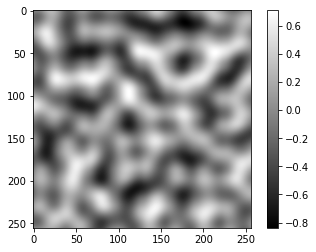

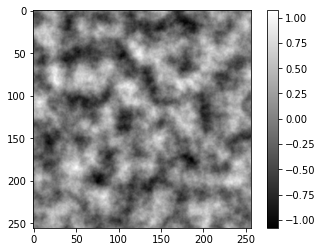

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from perlin_numpy import (
    generate_perlin_noise_2d, generate_fractal_noise_2d
)

np.random.seed(0)
noise = generate_perlin_noise_2d((256, 256), (8, 8))
plt.imshow(noise, cmap='gray', interpolation='lanczos')
plt.colorbar()

np.random.seed(0)
noise = generate_fractal_noise_2d((256, 256), (8, 8), 5)
plt.figure()
plt.imshow(noise, cmap='gray', interpolation='lanczos')
plt.colorbar()
plt.show()
    